# #30DayChartChallenge: Polar Plot Time Series of Modelled Salt Front in the Delaware Bay

### Libraries

In [997]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patheffects as path_effects
import cmocean
import cmocean.cm as cmo

### Import Salt Front Data

Read 2016 data

In [998]:
saltfront_2016 = pd.read_csv('saltfront_2016.csv', index_col=0 )
saltfront_2016['date'] = pd.to_datetime(saltfront_2016.index)

In [999]:
saltfront_2016.head()

,s_rho,lon_rho,lat_rho,dist_mile,salt,date
ocean_time,,,,,,
2016-01-01,-0.96875,-75.549856,39.554065,57.853757,0.512911,2016-01-01
2016-01-02,-0.96875,-75.541527,39.556165,57.958055,0.513584,2016-01-02
2016-01-03,-0.96875,-75.563214,39.599991,61.272346,0.515504,2016-01-03
2016-01-04,-0.96875,-75.553418,39.648054,65.311734,0.512915,2016-01-04
2016-01-05,-0.96875,-75.550918,39.643383,64.907624,0.513948,2016-01-05


Read 2019 data

In [1000]:
saltfront_2019 = pd.read_csv('saltfront_2019.csv', index_col=0 )
saltfront_2019['date'] = pd.to_datetime(saltfront_2019.index)

In [1001]:
saltfront_2019.head()

,s_rho,lon_rho,lat_rho,dist_mile,salt,date
ocean_time,,,,,,
2019-01-01,-0.96875,-75.543999,39.547223,57.345343,0.513749,2019-01-01
2019-01-02,-0.96875,-75.549993,39.569700,58.925932,0.514861,2019-01-02
2019-01-03,-0.96875,-75.561611,39.475963,52.437812,0.514135,2019-01-03
2019-01-04,-0.96875,-75.561515,39.465171,51.663016,0.515406,2019-01-04
2019-01-05,-0.96875,-75.549081,39.553290,57.779059,0.513189,2019-01-05


### Setup Data for Plotting 

In [1002]:
def cover_full_year(sf_data, year, frequency):
    year_df_idx = pd.date_range(f'01-01-{year}',f'12-31-{year}', freq=frequency)
    sf_data.index = pd.DatetimeIndex(sf_data.index)
    sf_data = sf_data.reindex(year_df_idx, fill_value=np.nan)
    sf_data['date'] = pd.to_datetime(sf_data.index)
    return(sf_data)

In [1003]:
def upsample_data(sf_data, frequency):
    new_idx = pd.date_range(sf_data.date.min(), sf_data.date.max(), freq=frequency)
    sf_data.index = pd.DatetimeIndex(sf_data.index)
    sf_data = sf_data.reindex(new_idx, fill_value=np.nan)
    sf_data['dist_mile'] = sf_data['dist_mile'].interpolate(method='linear') # linearly interpolate between daily means
    sf_data['date'] = pd.DatetimeIndex(sf_data.index)
    return(sf_data)

In [1004]:
df_plot_2016 = saltfront_2016.copy()
df_plot_2016 = upsample_data(df_plot_2016, '1H') # Upsample to hourly to smooth color gradient when plotting
df_plot_2016 = cover_full_year(df_plot_2016, 2016, '1H') # make sure the data covers a full year

In [1005]:
df_plot_2019 = saltfront_2019.copy()
df_plot_2019 = upsample_data(df_plot_2019, '1H') # Upsample to hourly to smooth color gradient when plotting
df_plot_2019 = cover_full_year(df_plot_2019, 2019, '1H') # make sure the data covers a full year

In [1006]:
df_plot = pd.concat([df_plot_2016[['date','dist_mile']], df_plot_2019[['date','dist_mile']]])

In [1007]:
# Add time-related columns
df_plot['year'] = df_plot.date.dt.year # Add column for year
df_plot['mdate'] = mdates.date2num(df_plot.index.to_pydatetime()) # Convert dates to matplotlib dates
df_plot['tnorm'] = np.nan # for now, set normalized time column to NaN
df_plot['doy'] = df_plot.date.dt.dayofyear # compute doy #option 2
df_plot['doy_norm'] = np.nan # for now, set normalized doy column to NaN

In [1008]:
# Get list of years represented in the dataset
year_listed = df_plot.year.unique()
year_listed

array([2016, 2019], dtype=int64)

In [1009]:
# For each year in the dataset
for year in year_listed:
    year_df =  df_plot.loc[df_plot['year']==year]
    # normalize dates for that year to circle (2pi radians)
    df_plot.loc[df_plot['year']==year, 'tnorm'] = (year_df['mdate']-year_df['mdate'].min())/(year_df['mdate'].max()-year_df['mdate'].min())*2.*np.pi

# Plot data

In [1010]:
# Use an arbitrary year to get a set of dates for labeling at 8 places around polar chart
# dates_df = pd.DataFrame({'date':pd.date_range(start='2019-01-01', end='2019-12-31')})
dates_df = pd.DataFrame({'date':pd.date_range(start='2016-01-01', end='2016-12-26')})
date_labels = []
for i in range(0,8):
    date_labels.append(dates_df.iloc[round((dates_df.shape[0]/8)*i)].date.strftime("%m/%d"))
date_labels

['01/01', '02/15', '03/31', '05/15', '06/29', '08/14', '09/28', '11/12']

In [1011]:
# Get series representing Wilmington river mile
rm_Wilmington = df_plot.copy()
rm_Wilmington['dist_mile'] = 70

In [1012]:
# Get series representing south Philadelphia river mile
rm_Philadelphia = df_plot.copy()
rm_Philadelphia['dist_mile'] = 91

In [1013]:
# Get series representing 50 river mile
rm_50 = df_plot.copy()
rm_50['dist_mile'] = 50

In [1014]:
# Set y bound (y axis limits) to be used in the plot
y_bounds = [min(df_plot_2016.dist_mile.min(),df_plot_2019.dist_mile.min())-8, max(df_plot_2016.dist_mile.max(), df_plot_2019.dist_mile.max())+5]
y_bounds

[38.77466698064672, 93.58496888557525]

In [1015]:
df_plot.dist_mile.min()

46.77466698064672

In [1016]:
df_plot.dist_mile.max()

88.58496888557525

### define functions needed for line collection plotting

In [1017]:
# https://nbviewer.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha, path_effects=[path_effects.Stroke(capstyle="round")])
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc

### Plot 2016 Data

C:\Users\hcorson-dosch\Anaconda3\envs\geo\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
C:\Users\hcorson-dosch\Anaconda3\envs\geo\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


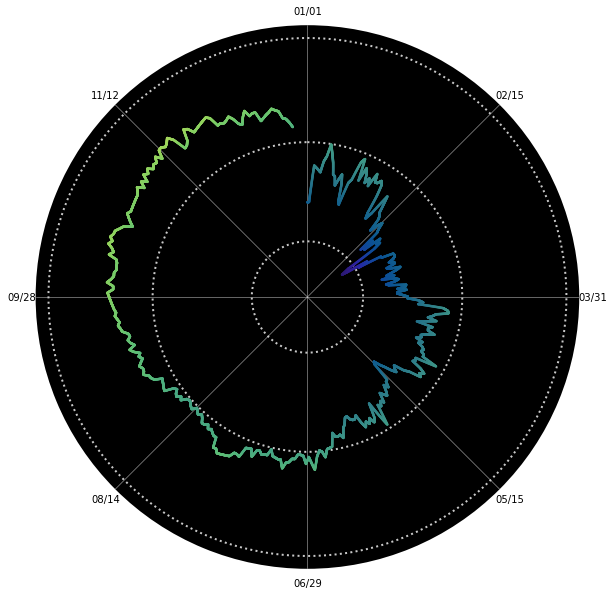

In [1018]:
# Plot w/ normalized date
fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111, projection='polar')
ax1.set_theta_direction(-1)
ax1.set_theta_zero_location("N")
norm = plt.Normalize(df_plot.dist_mile.min(), df_plot.dist_mile.max())
for year in [year_listed[0]]:
    lc = colorline(df_plot.loc[df_plot['year']==year].tnorm, df_plot.loc[df_plot['year']==year].dist_mile, cmap=cmo.haline, linewidth=2.5, norm=norm)
    lc.set_array(df_plot.loc[df_plot['year']==year].dist_mile)
    ax1.plot(rm_50.loc[rm_50['year']==year].tnorm,rm_50.loc[rm_50['year']==year].dist_mile, linewidth=2, color='#c9c9c9', zorder=0, ls='dotted')
    ax1.plot(rm_Wilmington.loc[rm_Wilmington['year']==year].tnorm,rm_Wilmington.loc[rm_Wilmington['year']==year].dist_mile, linewidth=2, color='#c9c9c9', zorder=-1, ls='dotted')
    ax1.plot(rm_Philadelphia.loc[rm_Philadelphia['year']==year].tnorm,rm_Philadelphia.loc[rm_Philadelphia['year']==year].dist_mile, linewidth=2, color='#c9c9c9', zorder=-1, ls='dotted')
ax1.tick_params(axis='x', colors='black')
ax1.set_ylim(y_bounds)
ax1.set_xticklabels(date_labels)
ax1.set_yticklabels([])
ax1.set_facecolor('black')
ax1.grid(linewidth=0.5, color='#c9c9c9')
ax1.grid(False, axis='y')
ax1.spines['polar'].set_visible(False)
plt.show()
fig.savefig('polar_plot_saltfront_2016.png', dpi=300, transparent=True)

### Plot 2019 data

C:\Users\hcorson-dosch\Anaconda3\envs\geo\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


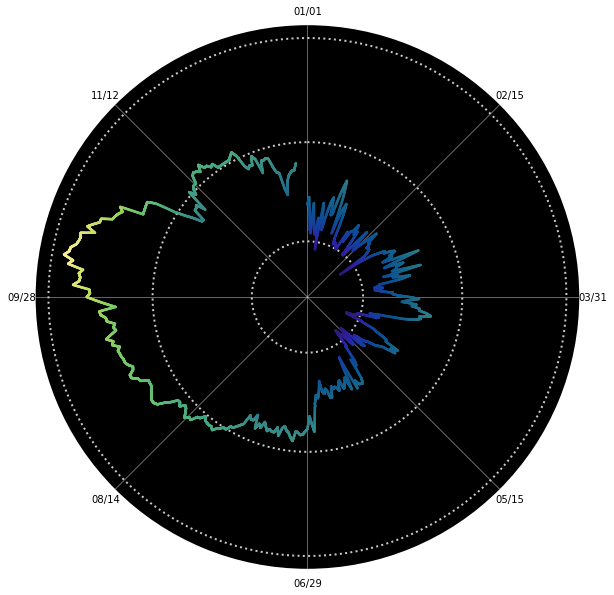

In [1019]:
# Plot w/ normalized date
fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111, projection='polar')
ax1.set_theta_direction(-1)
ax1.set_theta_zero_location("N")
norm = plt.Normalize(df_plot.dist_mile.min(), df_plot.dist_mile.max())
for year in [year_listed[1]]:
    lc = colorline(df_plot.loc[df_plot['year']==year].tnorm, df_plot.loc[df_plot['year']==year].dist_mile, cmap=cmo.haline, linewidth=2.5, norm=norm)
    lc.set_array(df_plot.loc[df_plot['year']==year].dist_mile)
    ax1.plot(rm_50.loc[rm_50['year']==year].tnorm,rm_50.loc[rm_50['year']==year].dist_mile, linewidth=2, color='#c9c9c9', zorder=0, ls='dotted')
    ax1.plot(rm_Wilmington.loc[rm_Wilmington['year']==year].tnorm,rm_Wilmington.loc[rm_Wilmington['year']==year].dist_mile, linewidth=2, color='#c9c9c9', zorder=-1, ls='dotted')
    ax1.plot(rm_Philadelphia.loc[rm_Philadelphia['year']==year].tnorm,rm_Philadelphia.loc[rm_Philadelphia['year']==year].dist_mile, linewidth=2, color='#c9c9c9', zorder=-1, ls='dotted')
ax1.tick_params(axis='x', colors='black')
ax1.set_ylim(y_bounds)
ax1.set_xticklabels(date_labels)
ax1.set_yticklabels([])
ax1.set_facecolor('black')
ax1.grid(linewidth=0.5, color='#c9c9c9')
ax1.grid(False, axis='y')
ax1.spines['polar'].set_visible(False)
plt.show()
fig.savefig('polar_plot_saltfront_2019.png', dpi=300, transparent=True)